# LAD vs. Skl

## Init

In [ ]:
from sklearn import linear_model

from f_data_prep import *
from f_drosophila_infer import *
from f_train import *

In [ ]:
data_all = np.loadtxt('../data_complete.txt')
median = np.median(data_all, axis=0)
# data_all = data_all - median
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

all_init, all_diff, comp_init, comp_diff = shuffle(all_init, all_diff, comp_init, comp_diff)

## LAD def

In [ ]:
def LAD_cv_quad(X, y, gene_comp=comp_ind, kf=10):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    train_ferror_list = []
    
    ferror_list=[]
    error_list_gene = []
    error1_list_cell = []
    error2_list_cell = []
    error22_list_cell = []
    
    w_list = []
    bias_list = []
    yp_list = []
    
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (tr, te) in (kfold.split(y)):
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
            train_X_init = np.copy(X_tr[:, comp_ind])
        else:
            X_init = np.copy(X_te)
            train_X_init = np.copy(X_tr)
        
        w,bias = infer_LAD(quad_tr, y_tr)
        w_list.append(w)
        bias_list.append(bias)
        
        train_ya = train_X_init + y_tr
        train_yp = train_X_init + bias + quad_tr.dot(w)
        error = np.sum(np.abs(train_yp - train_ya), axis=0)/np.sum(np.abs(train_ya), axis=0)
        train_ferror_list.append(error)
        
        ya = X_init + y_te
        yp = X_init + (bias + quad_te.dot(w))
        yp_list.append(yp)
        error = np.sum(np.abs(yp - ya), axis=0)/np.sum(np.abs(ya), axis=0)
        ferror_list.append(error)
    
        error = np.sum(np.abs(yp - ya), axis=0)
        error_list_gene.append(error)
        
        error = np.sum(np.abs(yp - ya), axis=1)
        error1_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))**(1/2)
        error2_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))
        error22_list_cell.append(error)
        
    dic = {
        'train_ferror': train_ferror_list,
        'ferror': ferror_list,
        'error_gene': error_list_gene,
        'error_cell_l1': error1_list_cell,
        'error_cell_l2': error2_list_cell,
        'error_cell_l22': error22_list_cell,
        'w': w_list,
        'bias': bias_list,
        'y_pred': yp_list
    }
        
    return dic


def skl_cv_quad(X, y, gene_comp=comp_ind, kf=10):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    train_ferror_list = []
    
    ferror_list=[]
    error_list_gene = []
    error1_list_cell = []
    error2_list_cell = []
    error22_list_cell = []
    
    coef = []
    intercept = []
    yp_list = []
    
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (tr, te) in (kfold.split(y)):
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
            train_X_init = np.copy(X_tr[:, comp_ind])
        else:
            X_init = np.copy(X_te)
            train_X_init = np.copy(X_tr)
        
        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        coef.append(regr.coef_)
        intercept.append(regr.intercept_)
        
        train_ya = train_X_init + y_tr
        train_yp = train_X_init + regr.predict(quad_tr)
        error = (np.sum(np.abs(train_yp - train_ya)**2, axis=0)/np.sum(np.abs(train_ya)**2, axis=0))**(1/2)
        train_ferror_list.append(error)
        
        ya = X_init + y_te
        yp = X_init + regr.predict(quad_te)
        yp_list.append(yp)
        error = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
        ferror_list.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=0))**(1/2)
        error_list_gene.append(error)
        
        error = np.sum(np.abs(yp - ya), axis=1)
        error1_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))**(1/2)
        error2_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))
        error22_list_cell.append(error)
    
    dic = {
        'train_ferror': train_ferror_list,
        'ferror': ferror_list,
        'error_gene': error_list_gene,
        'error_cell_l1': error1_list_cell,
        'error_cell_l2': error2_list_cell,
        'error_cell_l22': error22_list_cell,
        'coef': coef,
        'intercept': intercept,
        'y_pred': yp_list
    }
        
    return dic

def infer_all_LAD(X_all, X_comp, y_all, y_comp):
    res=[]
    results = LAD_cv_quad(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = LAD_cv_quad(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = LAD_cv_quad(X_comp, y_comp, gene_comp=[], kf=10)
    res.append(results)
    return res

def infer_all_skl(X_all, X_comp, y_all, y_comp):
    res=[]
    results = skl_cv_quad(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad(X_comp, y_comp, gene_comp=[], kf=10)
    res.append(results)
    return res

## Run & Save

In [ ]:
# LAD_quad = infer_all_LAD(all_init, comp_init, all_diff, comp_diff)    
# skl_quad = infer_all_skl(all_init, comp_init, all_diff, comp_diff)

In [ ]:
# with open('./pickles/LAD_quad.pkl', 'wb') as f:
#     pickle.dump(LAD_quad, f)
    
# with open('./pickles/skl_quad.pkl', 'wb') as f:
#     pickle.dump(skl_quad, f)

In [ ]:
with open('./pickles/LAD_quad.pkl', 'rb') as f:
    LAD_quad = pickle.load(f)
    
with open('./pickles/skl_quad.pkl', 'rb') as f:
    skl_quad = pickle.load(f)

## Results

### LAD vs. Skl: L1 error and L2 error
+ the Kolmogorov-Smirnov (KS test)

In [ ]:
import seaborn as sns
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[0]['error_cell_l1']), label='LAD')
sns.distplot(np.hstack(skl_quad[0]['error_cell_l1']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('absolute error (L-1 norm)')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[0]['error_cell_l2']), label='LAD')
sns.distplot(np.hstack(skl_quad[0]['error_cell_l2']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('absolute error (L-2 norm)')
plt.show()

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[0]['error_cell_l2']), np.hstack(skl_quad[0]['error_cell_l2'])))

In [ ]:
# fig = plt.figure(figsize=(8,12))
# ax1=fig.add_subplot(2,1,1)
# sns.distplot(np.hstack(LAD_quad[0][2]), bins=100, label='LAD')
# sns.distplot(np.hstack(skl_quad[0][3]), bins=100, label='skl')
# ax1.legend(bbox_to_anchor=(1,0.5))
# ax1.set_title('absolute error (L-1 norm)')
# ax2=fig.add_subplot(2,1,2)
# sns.distplot(np.hstack(LAD_quad[0][3]), bins=100, label='LAD')
# sns.distplot(np.hstack(skl_quad[0][2]), bins=100, label='skl')
# ax2.legend(bbox_to_anchor=(1,0.5))
# ax2.set_title('absolute error (L-2 norm)')
# # plt.show()
# plt.savefig('LAD vs. skl.pdf')

### LAD vs. skl: fractional errors

In [ ]:
% matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 27']
for i in range(3):
    plt.figure(figsize=(12,6))
    if i == 0:
        plt.plot(comp_ind, np.mean([LAD_quad[i]['ferror'][j][comp_ind] for j in range(10)], axis=0), 'o--', label='LAD')
        plt.plot(comp_ind, np.mean([skl_quad[i]['ferror'][j][comp_ind] for j in range(10)], axis=0), 'o--', label='skl')
    else:
        plt.plot(comp_ind, np.mean(LAD_quad[i]['ferror'], axis=0), 'o--', label='LAD')
        plt.plot(comp_ind, np.mean(skl_quad[i]['ferror'], axis=0), 'o--', label='skl')
    plt.title(labels[i])
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('gene')
    plt.ylabel('fractional error')
#     plt.ylim(0,1)
    plt.show()

plt.figure(figsize=(12,6))
plt.plot(range(99), np.mean(LAD_quad[0]['ferror'], axis=0), 'o--', label='LAD')
plt.plot(range(99), np.mean(skl_quad[0]['ferror'], axis=0), 'o--', label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('(99,27) to 99')
plt.xlabel('gene')
plt.ylabel('fractional error')
# plt.ylim(0,1)
plt.show()

### LAD (99,27) to 27 vs. (27,27) to 27: fractional errors

In [ ]:
% matplotlib inline
matplotlib.rcParams.update({'font.size': 28})
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 27']
plt.figure(figsize=(12,6))
# plt.plot(comp_ind, np.mean([LAD_quad[0]['ferror'][j][comp_ind] for j in range(10)], axis=0), 'o--', label=labels[0])
plt.plot(comp_ind, np.mean(LAD_quad[1]['ferror'], axis=0), 'o--', label=labels[1])
plt.plot(comp_ind, np.mean(LAD_quad[2]['ferror'], axis=0), 'o--', label=labels[2])
plt.legend(loc='best')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.ylim(0,0.58)
# plt.ylim(0,1)
plt.show()

# plt.savefig('99vs27LAD.pdf', bbox_inches='tight')

In [ ]:
% matplotlib inline
matplotlib.rcParams.update({'font.size': 28})
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 27']
plt.figure(figsize=(12,6))
# plt.plot(comp_ind, np.mean([skl_quad[0]['ferror'][j][comp_ind] for j in range(10)], axis=0), 'o--', label=labels[0])
plt.plot(comp_ind, np.mean(skl_quad[1]['ferror'], axis=0), 'o--', linewidth=3, label=labels[1])
# plt.plot(comp_ind, np.mean(skl_quad[2]['ferror'], axis=0), 'o--', linewidth=3, label=labels[2])
plt.legend(bbox_to_anchor=(0.47,1))
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.ylim(0,0.63)
plt.show()

# plt.savefig('99skl.pdf', bbox_inches='tight')

In [ ]:
% matplotlib inline
matplotlib.rcParams.update({'font.size': 28})
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 27']
plt.figure(figsize=(12,6))
# plt.plot(comp_ind, np.mean([skl_quad[0]['ferror'][j][comp_ind] for j in range(10)], axis=0), 'o--', label=labels[0])
plt.plot(comp_ind, np.mean(skl_quad[1]['ferror'], axis=0), 'o--', linewidth=3, label=labels[1])
plt.plot(comp_ind, np.mean(skl_quad[2]['ferror'], axis=0), 'o--', linewidth=3, label=labels[2])
plt.legend(bbox_to_anchor=(0.47,1))
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.ylim(0,0.63)
plt.show()

# plt.savefig('99vs27skl.pdf', bbox_inches='tight')

### (99,27) to 99 LAD vs. skl: $L_{1}$ and $L_{2}^{2}$

In [ ]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[0]['error_cell_l1']), bins=100, label='LAD')
sns.distplot(np.hstack(skl_quad[0]['error_cell_l1']), bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Absolute errors')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[0]['error_cell_l22']), label='LAD')
sns.distplot(np.hstack(skl_quad[0]['error_cell_l22']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Squares of the errors')
plt.show()

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[0]['error_cell_l22']), np.hstack(skl_quad[0]['error_cell_l22'])))

print(stats.ttest_ind(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1']), equal_var=False))
print(stats.ttest_ind(np.hstack(LAD_quad[0]['error_cell_l22']), np.hstack(skl_quad[0]['error_cell_l22']), equal_var=False))

print(stats.mannwhitneyu(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1'])))
print(stats.mannwhitneyu(np.hstack(LAD_quad[0]['error_cell_l22']), np.hstack(skl_quad[0]['error_cell_l22'])))

### (99,27) to 27 LAD vs. skl: $L_{1}$ and $L_{2}^{2}$

In [ ]:
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[1]['error_cell_l1']), bins=100, label='LAD')
sns.distplot(np.hstack(skl_quad[1]['error_cell_l1']), bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Sums of Absolute Errors')
plt.show()
# plt.savefig('(99,27)to27_L1.pdf', bbox_inches='tight')

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[1]['error_cell_l22']), label='LAD')
sns.distplot(np.hstack(skl_quad[1]['error_cell_l22']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Sums of Squares of Errors')
plt.show()
# plt.savefig('(99,27)to27_L22.pdf', bbox_inches='tight')

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[1]['error_cell_l1']), np.hstack(skl_quad[1]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[1]['error_cell_l22']), np.hstack(skl_quad[1]['error_cell_l22'])))

print(stats.ttest_ind(np.hstack(LAD_quad[1]['error_cell_l1']), np.hstack(skl_quad[1]['error_cell_l1']), equal_var=False))
print(stats.ttest_ind(np.hstack(LAD_quad[1]['error_cell_l22']), np.hstack(skl_quad[1]['error_cell_l22']), equal_var=False))

print(stats.mannwhitneyu(np.hstack(LAD_quad[1]['error_cell_l1']), np.hstack(skl_quad[1]['error_cell_l1']), alternative='less'))
print(stats.mannwhitneyu(np.hstack(LAD_quad[1]['error_cell_l22']), np.hstack(skl_quad[1]['error_cell_l22']), alternative='less'))

print(np.median(np.hstack(LAD_quad[1]['error_cell_l1'])), np.median(np.hstack(skl_quad[1]['error_cell_l1'])))
print(np.median(np.hstack(LAD_quad[1]['error_cell_l22'])), np.median(np.hstack(skl_quad[1]['error_cell_l22'])))
print(np.mean(np.hstack(LAD_quad[1]['error_cell_l1'])), np.mean(np.hstack(skl_quad[1]['error_cell_l1'])))
print(np.mean(np.hstack(LAD_quad[1]['error_cell_l22'])), np.mean(np.hstack(skl_quad[1]['error_cell_l22'])))

### (27,27) to 27 LAD vs. skl: $L_{1}$ and $L_{2}^{2}$

In [ ]:
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[2]['error_cell_l1']), bins=100, label='LAD', kde_kws=dict(linewidth=3))
sns.distplot(np.hstack(skl_quad[2]['error_cell_l1']), bins=100, label='skl', kde_kws=dict(linewidth=3))
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Sums of Absolute Errors')
plt.show()
# plt.savefig('(27,27)to27_L1.pdf', bbox_inches='tight')

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[2]['error_cell_l22']), label='LAD', kde_kws=dict(linewidth=3))
sns.distplot(np.hstack(skl_quad[2]['error_cell_l22']), label='skl', kde_kws=dict(linewidth=3))
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Sums of Squares of Errors')
plt.show()
# plt.savefig('(27,27)to27_L22.pdf', bbox_inches='tight')

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[2]['error_cell_l1']), np.hstack(skl_quad[2]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[2]['error_cell_l22']), np.hstack(skl_quad[2]['error_cell_l22'])))

print(stats.ttest_ind(np.hstack(LAD_quad[2]['error_cell_l1']), np.hstack(skl_quad[2]['error_cell_l1']), equal_var=False))
print(stats.ttest_ind(np.hstack(LAD_quad[2]['error_cell_l22']), np.hstack(skl_quad[2]['error_cell_l22']), equal_var=False))

print(stats.mannwhitneyu(np.hstack(LAD_quad[2]['error_cell_l1']), np.hstack(skl_quad[2]['error_cell_l1']), alternative='less'))
print(stats.mannwhitneyu(np.hstack(LAD_quad[2]['error_cell_l22']), np.hstack(skl_quad[2]['error_cell_l22']), alternative='less'))

print(np.median(np.hstack(LAD_quad[1]['error_cell_l1'])), np.median(np.hstack(skl_quad[1]['error_cell_l1'])))
print(np.median(np.hstack(LAD_quad[1]['error_cell_l22'])), np.median(np.hstack(skl_quad[1]['error_cell_l22'])))
print(np.mean(np.hstack(LAD_quad[1]['error_cell_l1'])), np.mean(np.hstack(skl_quad[1]['error_cell_l1'])))
print(np.mean(np.hstack(LAD_quad[1]['error_cell_l22'])), np.mean(np.hstack(skl_quad[1]['error_cell_l22'])))

# Cell_select LAD vs. Skl
- 10 fold crossvalidation
- 607 (608) cells were excluded for each training, and used as testing cells

### Init

In [1]:
from sklearn import linear_model

from f_data_prep import *
from f_drosophila_infer import *
from f_train import *

import seaborn as sns

In [2]:
data_all = np.loadtxt('../data_complete.txt')
median = np.median(data_all, axis=0)
# data_all = data_all - median
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

## Def

In [3]:
def LAD_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False)
    
    train_ferror_list = []
    
    ferror_list=[]
    error_list_gene = []
    error1_list_cell = []
    error2_list_cell = []
    error22_list_cell = []
    
    w_list = []
    bias_list = []
    yp_list = []
    
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (cell_in, cell_ex) in (kfold.split(range(6078))):
        te = np.hstack([cell_ex+(6078*i) for i in range(5)])
        tr = np.delete(range(30390), te)
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
            train_X_init = np.copy(X_tr[:, comp_ind])
        else:
            X_init = np.copy(X_te)
            train_X_init = np.copy(X_tr)
        
        w,bias = infer_LAD(quad_tr, y_tr)
        w_list.append(w)
        bias_list.append(bias)
        
        train_yp = train_X_init + (bias + quad_tr.dot(w))
        train_ya = train_X_init + y_tr
        error = np.sum(np.abs(train_yp - train_ya), axis=0)/np.sum(np.abs(train_ya), axis=0)
        train_ferror_list.append(error)
        
        ya = X_init + y_te
        yp = X_init + (bias + quad_te.dot(w))
        yp_list.append(yp)
        error = np.sum(np.abs(yp - ya), axis=0)/np.sum(np.abs(ya), axis=0)
        ferror_list.append(error)
    
        error = np.sum(np.abs(yp - ya), axis=0)
        error_list_gene.append(error)
        
        error = np.sum(np.abs(yp - ya), axis=1)
        error1_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))**(1/2)
        error2_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))
        error22_list_cell.append(error)
    
    dic = {
        'train_ferror': train_ferror_list,
        'ferror': ferror_list,
        'error_gene': error_list_gene,
        'error_cell_l1': error1_list_cell,
        'error_cell_l2': error2_list_cell,
        'error_cell_l22': error22_list_cell,
        'w': w_list,
        'bias': bias_list,
        'y_pred': yp_list
    }
        
    return dic

def skl_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    train_ferror_list = []
    
    ferror_list=[]
    error_list_gene = []
    error1_list_cell = []
    error2_list_cell = []
    error22_list_cell = []
    
    coef = []
    intercept = []
    yp_list = []
    
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (cell_in, cell_ex) in (kfold.split(range(6078))):
        te = np.hstack([cell_ex+(6078*i) for i in range(5)])
        tr = np.delete(range(30390), te)
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
            train_X_init = np.copy(X_tr[:, comp_ind])
        else:
            X_init = np.copy(X_te)
            train_X_init = np.copy(X_tr)
        
        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        coef.append(regr.coef_)
        intercept.append(regr.intercept_)
        
        train_ya = train_X_init + y_tr
        train_yp = train_X_init + regr.predict(quad_tr)
        error = (np.sum(np.abs(train_yp - train_ya)**2, axis=0)/np.sum(np.abs(train_ya)**2, axis=0))**(1/2)
        train_ferror_list.append(error)
        
        ya = X_init + y_te
        yp = X_init + regr.predict(quad_te)
        yp_list.append(yp)
        error = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
        ferror_list.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=0))**(1/2)
        error_list_gene.append(error)
        
        error = np.sum(np.abs(yp - ya), axis=1)
        error1_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))**(1/2)
        error2_list_cell.append(error)
        
        error = (np.sum(np.abs(yp - ya)**2, axis=1))
        error22_list_cell.append(error)
    
    dic = {
        'train_ferror': train_ferror_list,
        'ferror': ferror_list,
        'error_gene': error_list_gene,
        'error_cell_l1': error1_list_cell,
        'error_cell_l2': error2_list_cell,
        'error_cell_l22': error22_list_cell,
        'w': coef,
        'bias': intercept,
        'y_pred': yp_list
    }
        
    return dic

def infer_all_LAD(X_all, X_comp, y_all, y_comp):
    res=[]
    results = LAD_cv_quad_cellselect(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = LAD_cv_quad_cellselect(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = LAD_cv_quad_cellselect(X_comp, y_comp, gene_comp=[], kf=10)
    res.append(results)
    return res

def infer_all_skl(X_all, X_comp, y_all, y_comp):
    res=[]
    results = skl_cv_quad_cellselect(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_comp, y_comp, gene_comp=[], kf=10)
    res.append(results)
    return res

## Run & Save

In [4]:
# LAD_quad_cellselect = infer_all_LAD(all_init, comp_init, all_diff, comp_diff)
# skl_quad_cellselect = infer_all_skl(all_init, comp_init, all_diff, comp_diff)

In [5]:
# with open('./pickles/LAD_quad_cellselect.pkl', 'wb') as f:
#     pickle.dump(LAD_quad_cellselect, f)

# with open('./pickles/skl_quad_cellselect.pkl', 'wb') as f:
#     pickle.dump(skl_quad_cellselect, f)

In [6]:
with open('./pickles/LAD_quad_cellselect.pkl', 'rb') as f:
    LAD_quad = pickle.load(f)
    
with open('./pickles/skl_quad_cellselect.pkl', 'rb') as f:
    skl_quad = pickle.load(f)

## Results

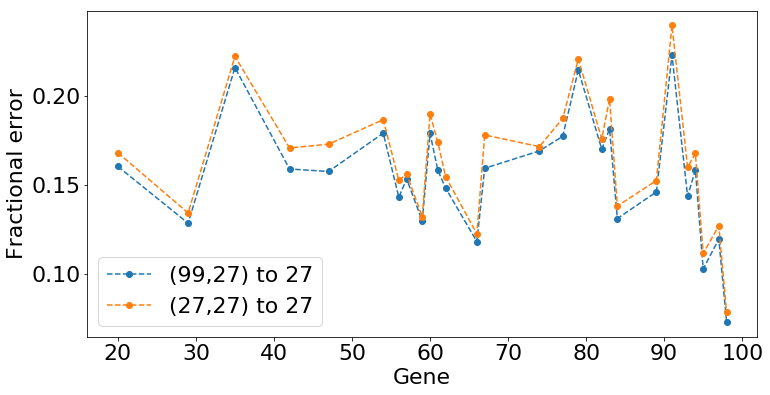

In [7]:
matplotlib.rcParams.update({'font.size': 22})
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 27']
plt.figure(figsize=(12,6))
plt.plot(comp_ind, np.mean(LAD_quad[1]['ferror'], axis=0), 'o--', label=labels[1])
plt.plot(comp_ind, np.mean(LAD_quad[2]['ferror'], axis=0), 'o--', label=labels[2])
plt.legend(loc='best')
plt.xlabel('Gene')
plt.ylabel('Fractional error')
plt.show()

### (99,27) to 99 LAD vs. skl: $L_{1}$ and $L_{2}^{2}$

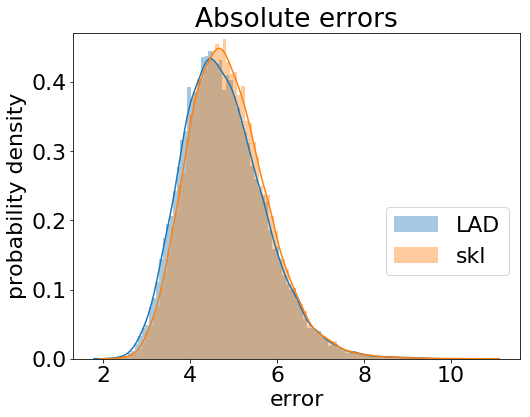

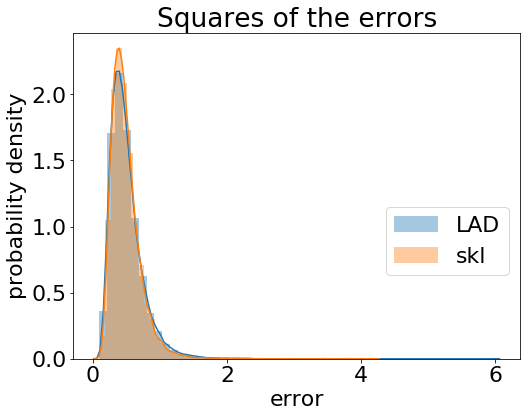

Ks_2sampResult(statistic=0.05274761434682462, pvalue=3.7976020321903726e-37)
Ks_2sampResult(statistic=0.023889437314906226, pvalue=5.871419537910975e-08)
Ttest_indResult(statistic=-12.564489142044211, pvalue=3.67198710914182e-36)
Ttest_indResult(statistic=5.782889498775507, pvalue=7.379354627289676e-09)
MannwhitneyuResult(statistic=432181380.0, pvalue=6.3917584893928264e-43)
MannwhitneyuResult(statistic=459150243.0, pvalue=0.11236316924547396)


In [8]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[0]['error_cell_l1']), bins=100, label='LAD')
sns.distplot(np.hstack(skl_quad[0]['error_cell_l1']), bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Absolute errors')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[0]['error_cell_l22']), label='LAD')
sns.distplot(np.hstack(skl_quad[0]['error_cell_l22']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Squares of the errors')
plt.show()

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[0]['error_cell_l22']), np.hstack(skl_quad[0]['error_cell_l22'])))

print(stats.ttest_ind(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1']), equal_var=False))
print(stats.ttest_ind(np.hstack(LAD_quad[0]['error_cell_l22']), np.hstack(skl_quad[0]['error_cell_l22']), equal_var=False))

print(stats.mannwhitneyu(np.hstack(LAD_quad[0]['error_cell_l1']), np.hstack(skl_quad[0]['error_cell_l1'])))
print(stats.mannwhitneyu(np.hstack(LAD_quad[0]['error_cell_l22']), np.hstack(skl_quad[0]['error_cell_l22'])))

### (99,27) to 27, LAD vs. skl: $L_{1}$ and $L_{2}^{2}$

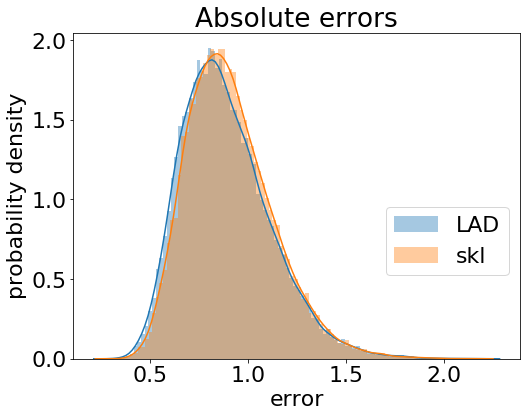

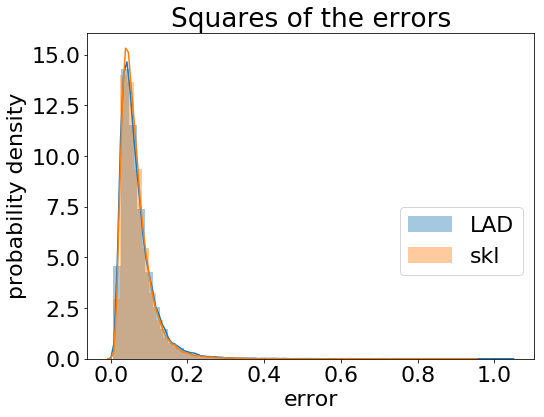

Ks_2sampResult(statistic=0.050773280684435707, pvalue=1.8924423552213634e-34)
Ks_2sampResult(statistic=0.022869364922671942, pvalue=2.5018593870891636e-07)
Ttest_indResult(statistic=-11.839530451936747, pvalue=2.646285303276305e-32)
Ttest_indResult(statistic=4.098458823444711, pvalue=4.1645554921833316e-05)
MannwhitneyuResult(statistic=432972095.0, pvalue=9.136562207443686e-41)
MannwhitneyuResult(statistic=459947651.0, pvalue=0.19895212983678262)


In [9]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[1]['error_cell_l1']), bins=100, label='LAD')
sns.distplot(np.hstack(skl_quad[1]['error_cell_l1']), bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Absolute errors')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[1]['error_cell_l22']), label='LAD')
sns.distplot(np.hstack(skl_quad[1]['error_cell_l22']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Squares of the errors')
plt.show()

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[1]['error_cell_l1']), np.hstack(skl_quad[1]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[1]['error_cell_l22']), np.hstack(skl_quad[1]['error_cell_l22'])))

print(stats.ttest_ind(np.hstack(LAD_quad[1]['error_cell_l1']), np.hstack(skl_quad[1]['error_cell_l1']), equal_var=False))
print(stats.ttest_ind(np.hstack(LAD_quad[1]['error_cell_l22']), np.hstack(skl_quad[1]['error_cell_l22']), equal_var=False))

print(stats.mannwhitneyu(np.hstack(LAD_quad[1]['error_cell_l1']), np.hstack(skl_quad[1]['error_cell_l1'])))
print(stats.mannwhitneyu(np.hstack(LAD_quad[1]['error_cell_l22']), np.hstack(skl_quad[1]['error_cell_l22'])))

### (27,27) to 27 LAD vs. skl: $L_{1}$ and $L_{2}^{2}$

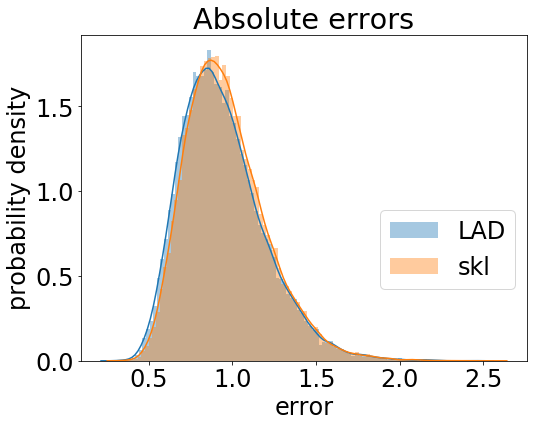

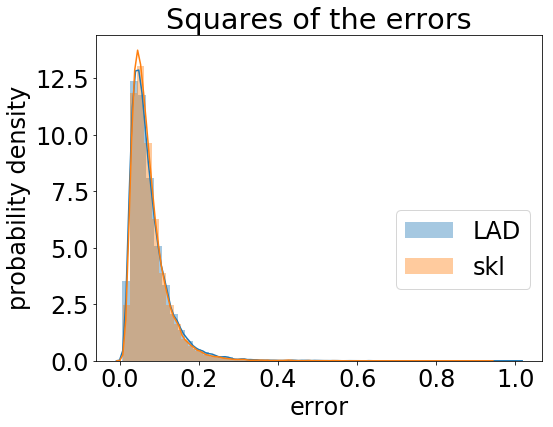

Ks_2sampResult(statistic=0.04685751892069756, pvalue=2.1022494420274262e-29)
Ks_2sampResult(statistic=0.023362948338269185, pvalue=1.250507553057305e-07)
Ttest_indResult(statistic=-10.359271425513079, pvalue=3.9861632876725967e-25)
Ttest_indResult(statistic=3.7834096157693473, pvalue=0.00015484412865394498)
MannwhitneyuResult(statistic=436005311.0, pvalue=4.9289784511405064e-33)
MannwhitneyuResult(statistic=460118964.0, pvalue=0.221789794459743)


In [10]:
matplotlib.rcParams.update({'font.size': 24})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[2]['error_cell_l1']), bins=100, label='LAD')
sns.distplot(np.hstack(skl_quad[2]['error_cell_l1']), bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Absolute errors')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[2]['error_cell_l22']), label='LAD')
sns.distplot(np.hstack(skl_quad[2]['error_cell_l22']), label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('error')
plt.ylabel('probability density')
plt.title('Squares of the errors')
plt.show()

import scipy.stats as stats
print(stats.ks_2samp(np.hstack(LAD_quad[2]['error_cell_l1']), np.hstack(skl_quad[2]['error_cell_l1'])))
print(stats.ks_2samp(np.hstack(LAD_quad[2]['error_cell_l22']), np.hstack(skl_quad[2]['error_cell_l22'])))

print(stats.ttest_ind(np.hstack(LAD_quad[2]['error_cell_l1']), np.hstack(skl_quad[2]['error_cell_l1']), equal_var=False))
print(stats.ttest_ind(np.hstack(LAD_quad[2]['error_cell_l22']), np.hstack(skl_quad[2]['error_cell_l22']), equal_var=False))

print(stats.mannwhitneyu(np.hstack(LAD_quad[2]['error_cell_l1']), np.hstack(skl_quad[2]['error_cell_l1'])))
print(stats.mannwhitneyu(np.hstack(LAD_quad[2]['error_cell_l22']), np.hstack(skl_quad[2]['error_cell_l22'])))

### for .pdf
- (99,27) to 99 LAD vs. skl: $L_{1}$ and $L_{2}^{2}$ 

In [11]:
# matplotlib.rcParams.update({'font.size': 22})
# fig = plt.figure(figsize=(10,6))
# ax1=fig.add_subplot(1,2,1)
# sns.distplot(np.hstack(LAD_quad[0]['error_cell_l1']), bins=100, label='LAD')
# sns.distplot(np.hstack(skl_quad[0]['error_cell_l1']), bins=100, label='skl')
# ax1.legend(bbox_to_anchor=(1,1))
# ax1.set_title('L1 norm of the errors')
# ax2=fig.add_subplot(1,2,2)
# sns.distplot(np.hstack(LAD_quad[0]['error_cell_l22']), label='LAD')
# sns.distplot(np.hstack(skl_quad[0]['error_cell_l22']), label='skl')
# ax2.legend(bbox_to_anchor=(1,1))
# ax2.set_title('L2 norm of the errors')
# # plt.show()
# plt.savefig('LAD vs. skl cell_ex.pdf', bbox_inches='tight')

### LAD (99,27) to 27 vs. (27,27) to 27: $L_{1}$

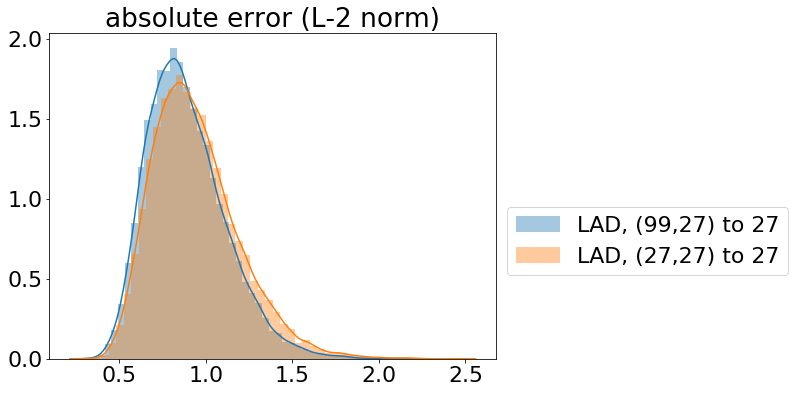

In [12]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(LAD_quad[1]['error_cell_l1']), label='LAD, (99,27) to 27')
sns.distplot(np.hstack(LAD_quad[2]['error_cell_l1']), label='LAD, (27,27) to 27')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('absolute error (L-2 norm)')
plt.show()

### skl (99,27) to 27 vs. (27,27) to 27: $L_{1}$

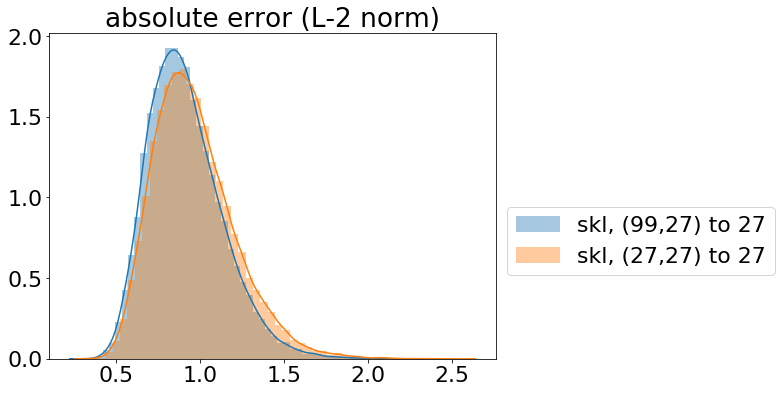

In [13]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
sns.distplot(np.hstack(skl_quad[1]['error_cell_l1']), label='skl, (99,27) to 27')
sns.distplot(np.hstack(skl_quad[2]['error_cell_l1']), label='skl, (27,27) to 27')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('absolute error (L-2 norm)')
plt.show()